In [2]:
%matplotlib inline

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# from xgboost.sklearn import XGBClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# Plot a confusion matrix
def plot_cm(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    fig = plt.figure(figsize = (5,5))
    sns.set(font_scale = 1.25)
    sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = ',.0f', annot_kws = {'size': 14})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();

# Model diagnostics
def model_results(y, y_pred, y_pred_proba):
    print(metrics.classification_report(y, y_pred))
    print('Area under ROC:', metrics.roc_auc_score(y, y_pred_proba[:, 1]))
    plot_cm(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
# Cross-validation model fitting and diagnostics
def model_results_cv(X, y, classifier):
    y_pred = cross_val_predict(classifier, X, y, cv = 10)
    y_pred_proba = cross_val_predict(classifier, X, y, cv = 10, method='predict_proba')
    model_results(y, y_pred, y_pred_proba)

In [8]:
wine = pd.read_csv('C:/Projects/wining-and-mining/data/raw/winemag-data-130k-v2.csv', index_col = 0)

# Value for money wines

## Simple ratio of score to price

One way to think of value for money, is to divide the price of the wine into the score. The higher the ration of score to price, the greater the value for money. We can then figure out what the best value for money wine is by:
+ price range
+ country
+ winery
+ variety

## Regression model to predict price and then flag wines that have prices lower than expected

# Variation between raters

+ Do raters rate the same wines differently? 
+ Do some raters have systematic biases towards specific countries, wineries, or varieties?

# Reverse-engineer descriptions of top wines

Use a naive bases binomial classifier to work out which words in descriptions are associated with high-scoring wines. We can then construct our own descriptions for high-scoring wines and see what our model would predict the scores to be.

In [9]:
wine.head()
wine['excellent+'] = np.where(wine['points'] >= 90, 1, 0)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Preprocess data

In [10]:
y = wine['excellent+']
X = wine.drop('excellent+', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Modelling

In [ ]:
data = wine[['excellent+', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegressionCV(random_state = 0, cv = 10)

X_train.shape
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(classifier.fit(X_train, y_train), prefit = True)
X_train_selected = model.transform(X_train)
X_train_selected.shape
X_test_selected = X_test.loc[:, model.get_support()]

# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LogisticRegressionCV(random_state = 0, cv = 10))),
#   ('classification', LogisticRegressionCV())
# ])
# clf.fit(X_train, y_train)
classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_test_selected, y_test, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_test_selected, y_test, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
data = wine[['excellent+', 'log_price', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_train, y_train, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_train, y_train, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))

# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# y_pred_proba = classifier.predict_proba(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(metrics.classification_report(y_test, y_pred))
# print(metrics.accuracy_score(y_test, y_pred))
# print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
model = classifier.fit(X_train, y_train)
exp_coef = pd.DataFrame({'exp_coef': np.exp(model.coef_[0])}, index = X.columns).sort_values('exp_coef', ascending = 0)
exp_coef.head(10)          
exp_coef.tail(10) 

In [ ]:
data2 = wine[['excellent+', 'log_price']]

X2 = data2.drop('excellent+', axis = 1)
y = data2['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred2 = cross_val_predict(classifier, X2, y, cv = 10)
y_pred_probs2 = cross_val_predict(classifier, X2, y, cv = 10, method='predict_proba')
classifier.fit(X_train, y_train)
# y_pred_probs = classifier.predict(X_test)

print(confusion_matrix(y, y_pred2))
print(metrics.classification_report(y, y_pred2))
print(metrics.accuracy_score(y, y_pred2))
print(metrics.roc_auc_score(y, y_pred_probs2[:, 1]))

## Use wine description to predict score

In [11]:
# Compute word counts
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['description'])
X_test_vec = vectorizer.transform(X_test['description'])

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     60658
          1       0.72      0.78      0.75     36820

avg / total       0.81      0.80      0.81     97478

Area under ROC: 0.882017501387


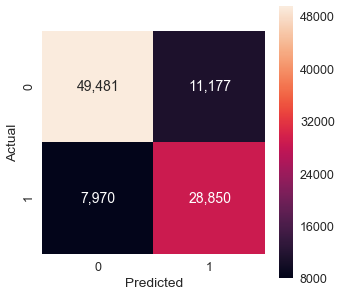

In [12]:
# Fit a naive bayes model to the training data.
nb_classifier = MultinomialNB()
model_results_cv(X_train_vec, y_train, nb_classifier)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     20268
          1       0.72      0.79      0.75     12225

avg / total       0.81      0.81      0.81     32493

Area under ROC: 0.883305043703


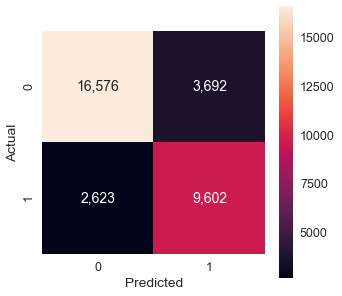

In [13]:
nb_classifier.fit(X_train_vec, y_train)
y_predict = nb_classifier.predict(X_test_vec)
y_predict_proba = nb_classifier.predict_proba(X_test_vec)
model_results(y_test, y_predict, y_predict_proba)

In [38]:
pd.DataFrame({'y_predict': y_predict, 
              'y_predict_proba': y_predict_proba[:, 0]})

,y_predict,y_predict_proba
0,0,1.000000e+00
1,1,1.044344e-02
2,0,9.983053e-01
3,1,4.211216e-01
4,0,9.501149e-01
5,0,9.998989e-01
6,0,9.756564e-01
7,0,8.304256e-01
8,0,7.174586e-01
9,0,9.997202e-01


In [53]:
y_test.head()

70354     0
4473      1
59653     0
107856    1
64547     0
Name: excellent+, dtype: int64

In [15]:
incorrectly_classified_idx = (y_test != y_predict).tolist()
incorrectly_classified = pd.concat([X_test.reset_index(), 
                                    y_test.reset_index(),
                                   pd.DataFrame({'y_predict': y_predict,
                                                 'y_predict_proba': y_predict_proba[:, 1]})],
                                  axis = 1)[incorrectly_classified_idx]

In [16]:
incorrectly_classified

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,index,excellent+,y_predict,y_predict_proba
8,80479,Italy,"Ripe and full bodied, this has aromas of light...",Archineri Rosso,90,35.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Pietradolce 2012 Archineri Rosso (Etna),Nerello Mascalese,Pietradolce,80479,1,0,0.282541
13,96379,France,"This wine has some richness, with ripe black c...",NaN,88,45.0,Bordeaux,Haut-Médoc,NaN,Roger Voss,@vossroger,Château Balac 2013 Haut-Médoc,Bordeaux-style Red Blend,Château Balac,96379,0,1,0.847581
15,29341,US,"There is a delicious, citrusy kick to this win...",Guadalupe Vineyard,92,40.0,Oregon,Willamette Valley,NaN,Paul Gregutt,@paulgwine,Soléna 2009 Guadalupe Vineyard Pinot Noir,Pinot Noir,Soléna,29341,1,0,0.274577
17,97909,US,"More than three quarters Syrah, this is made f...",Estate Syrah-Mourvèdre,85,29.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Wilridge 2009 Estate Syrah-Mourvèdre Syrah-Mou...,Syrah-Mourvèdre,Wilridge,97909,0,1,0.822312
19,53068,US,Labeled a “Super Tuscan-Style Blend” this is 3...,Flying Colors,89,29.0,Washington,Red Mountain,Columbia Valley,Paul Gregutt,@paulgwine,Genoa 2011 Flying Colors Red (Red Mountain),Red Blend,Genoa,53068,0,1,0.982826
20,38434,Hungary,"This dry Furmint is brilliant gold in color, w...",Szent Tamás Betsek Vineyards,93,25.0,Tokaji,NaN,NaN,Jeff Jenssen,@worldwineguys,Dobogó 2011 Szent Tamás Betsek Vineyards (Tok...,Furmint,Dobogó,38434,1,0,0.085428
24,80277,US,"Roasted coffee bean, ember and spice aromas ta...",Abracadabra,88,22.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Brian Carter Cellars 2013 Abracadabra Red (Col...,Red Blend,Brian Carter Cellars,80277,0,1,0.816994
33,85931,Portugal,This is a spicy earthy wine with its high perc...,Sem Barrica Unoaked,88,22.0,Alentejano,NaN,NaN,Roger Voss,@vossroger,Herdade das Servas 2015 Sem Barrica Unoaked Re...,Portuguese Red,Herdade das Servas,85931,0,1,0.995261
40,24374,US,"Dry, smooth and classy, with rich chocolate, b...",Whitestone Vineyard,88,40.0,California,Central Coast,Central Coast,NaN,NaN,Clos La Chance 2008 Whitestone Vineyard Cabern...,Cabernet Sauvignon,Clos La Chance,24374,0,1,0.625904
44,21604,Argentina,"Generous, sizable aromas of cassis, blackberry...",NaN,91,27.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Doña Silvina 2011 Malbec (Mendoza),Malbec,Doña Silvina,21604,1,0,0.071181
